In [2]:
#import dependencies
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import models, layers
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
BATCH_SIZE = 8
IMAGE_SIZE1 = 400
IMAGE_SIZE2 = 300
CHANNELS=3
EPOCHS=40

In [4]:
# dataset load with keras preprocessing 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "G:/Notebook_Data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE1,IMAGE_SIZE2),
    batch_size=BATCH_SIZE
)

Found 96 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['Digital', 'Original']

In [6]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 400, 300, 3)
[1 0 0 0 1 1 0 0]


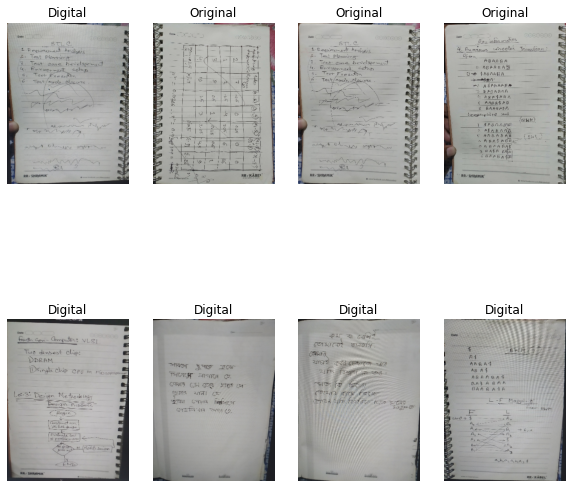

In [7]:
#display a portion of dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.savefig("Train dataset.png",format="png",facecolor="white")
        plt.axis("off")

In [8]:
#split the dataset into train, test & validatoin set

def get_dataset_partitions_tf(ds, train_split=0.75, val_split=0.17,test_split=0.08, shuffle=True, shuffle_size=10):
    assert (train_split +val_split + test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds, test_ds

In [9]:
train_ds,val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

9

In [11]:
len(val_ds)

2

In [12]:
len(test_ds)

1

In [13]:
# cache dataset into memory, shuffle, prepare next batch of data while model is executing previous batch 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# resize & rescale
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE1, IMAGE_SIZE2),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [15]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
input_shape = (BATCH_SIZE,IMAGE_SIZE1, IMAGE_SIZE2, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(.2),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.BatchNormalization(input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (8, 400, 300, 3)          0         
                                                                 
 conv2d (Conv2D)             (8, 398, 298, 32)         896       
                                                                 
 batch_normalization (BatchN  (8, 398, 298, 32)        128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (8, 199, 149, 32)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (8, 199, 149, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (8, 197, 147, 32)        

In [18]:
#adapt learning rate

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
   validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/40
9/9 [==============================] - 20s 2s/step - loss: 3.1132 - accuracy: 0.5417 - val_loss: 0.6832 - val_accuracy: 0.5625
Epoch 2/40
9/9 [==============================] - 12s 1s/step - loss: 0.3378 - accuracy: 0.8056 - val_loss: 0.6689 - val_accuracy: 0.5625
Epoch 3/40
9/9 [==============================] - 12s 1s/step - loss: 0.1848 - accuracy: 0.9306 - val_loss: 0.6516 - val_accuracy: 0.5625
Epoch 4/40
9/9 [==============================] - 12s 1s/step - loss: 0.0757 - accuracy: 0.9583 - val_loss: 0.6588 - val_accuracy: 0.5625
Epoch 5/40
9/9 [==============================] - 12s 1s/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.8064 - val_accuracy: 0.5625
Epoch 6/40
9/9 [==============================] - 12s 1s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.7345 - val_accuracy: 0.5625
Epoch 7/40
9/9 [==============================] - 12s 1s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5906 - val_accuracy: 0.5625
Epoch 8/40
9/9 [==================

In [20]:
scores = model.evaluate(test_ds)
scores

1/1 [==============================] - 2s 2s/step - loss: 0.0894 - accuracy: 1.0000


[0.08939002454280853, 1.0]

In [21]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 9}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
len(history.history['loss'])

40

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

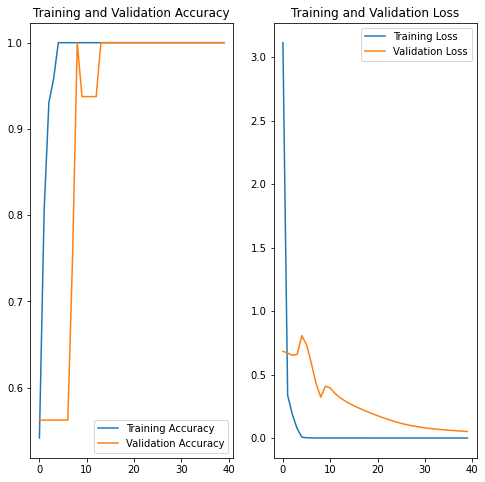

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Original
1/1 [==============================] - 1s 530ms/step
predicted label: Original


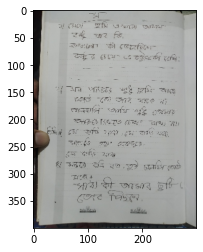

In [26]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 66ms/step


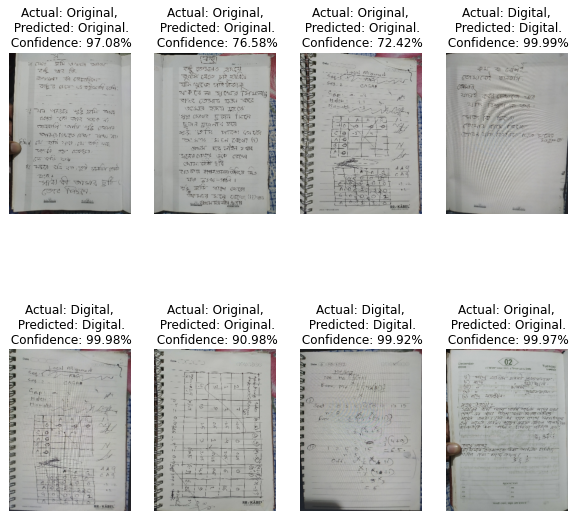

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.savefig('Test Dataset Prediction Using The Trained Model.png',format='png',facecolor='white')
        plt.axis("off")

In [29]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
predicted_labels = []
true_labels = []

In [30]:
for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels.extend(tf.argmax(predictions, axis=1))
    true_labels.extend(labels)

1/1 [==============================] - 0s 277ms/step


In [31]:
predicted_labels = tf.stack(predicted_labels, axis=0).numpy()
true_labels = tf.stack(true_labels, axis=0).numpy()

In [32]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

In [33]:
precision,recall,f1, accuracy

(1.0, 1.0, 1.0, 1.0)

In [34]:
pre = round(100 * precision,2)
re = round(100 * recall,2)
f = round(100 * f1,2)
accu = round(100 * accuracy,2)

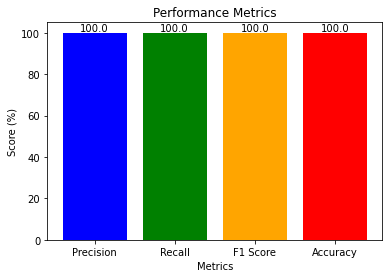

In [35]:
labels = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
values = [pre, re ,f , accu]


plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.xlabel('Metrics')
plt.ylabel('Score (%)')
plt.title('Performance Metrics')
plt.savefig("Performance Metrics.png", format='png',facecolor = "white")
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(true_labels,predicted_labels)

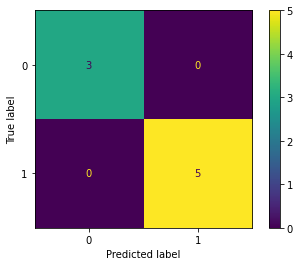

In [37]:
cm_display = ConfusionMatrixDisplay(cm).plot()

1/1 [==============================] - 0s 72ms/step
Predicted Class: Original
Confidence: 59.64%


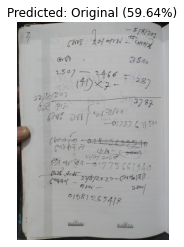

In [39]:
# Test single new image out of dataset.
from tensorflow.keras.preprocessing import image

# Path to your test image
image_path = "G:/test_notebook/5.jpg"

def preprocess_image(image_path, target_size=(IMAGE_SIZE1, IMAGE_SIZE2)):
    # Load the image with the target size
    img = image.load_img(image_path, target_size=target_size)
    # Convert the image to an array
    img_array = image.img_to_array(img)
    # Rescale the pixel values (if required, depending on your model preprocessing)
    img_array = img_array / 255.0  # Match the Rescaling layer
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Preprocess the test image
test_image = preprocess_image(image_path)

# Make a prediction
predictions = model.predict(test_image)
predicted_class = class_names[np.argmax(predictions[0])]
confidence = round(100 * np.max(predictions[0]), 2)

# Display the results
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence}%")

# Optional: Visualize the image with the prediction
plt.imshow(image.load_img(image_path))
plt.title(f"Predicted: {predicted_class} ({confidence}%)")
plt.axis("off")
plt.show()


1/1 [==============================] - 0s 77ms/step
Predicted Class: Original
Confidence: 59.64%


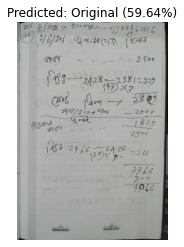

In [43]:
from tensorflow.keras.preprocessing import image

# Path to your test image
image_path = "G:/test_notebook/4.jpg"

# Preprocess the test image
test_image = preprocess_image(image_path)

# Make a prediction
predictions = model.predict(test_image)
predicted_class = class_names[np.argmax(predictions[0])]
confidence = round(100 * np.max(predictions[0]), 2)

# Display the results
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence}%")

# Optional: Visualize the image with the prediction
plt.imshow(image.load_img(image_path))
plt.title(f"Predicted: {predicted_class} ({confidence}%)")
plt.axis("off")
plt.show()

In [ ]:
import pickle
#pickle.dump(model,open("maize_leave_detection_model_98.36.pkl","wb"))

In [ ]:
import pickle
#model = pickle.load(open("maize_leave_detection_model_99.11.pkl","rb"))

In [45]:
scores_train = model.evaluate(val_ds)
scores_train

2/2 [==============================] - 1s 269ms/step - loss: 0.0513 - accuracy: 1.0000


[0.05133471637964249, 1.0]